<a href="https://colab.research.google.com/github/anguelos/cv_ws_2023/blob/main/pytorch_hello.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Add this file to your google drive

https://drive.google.com/file/d/1f-aifnIpNVUEmugf9H_mgorGnE2Y9mXg/view?usp=share_link

1) Add a shortcut to this URL inside the drive

2)Verify shortcut in your drive
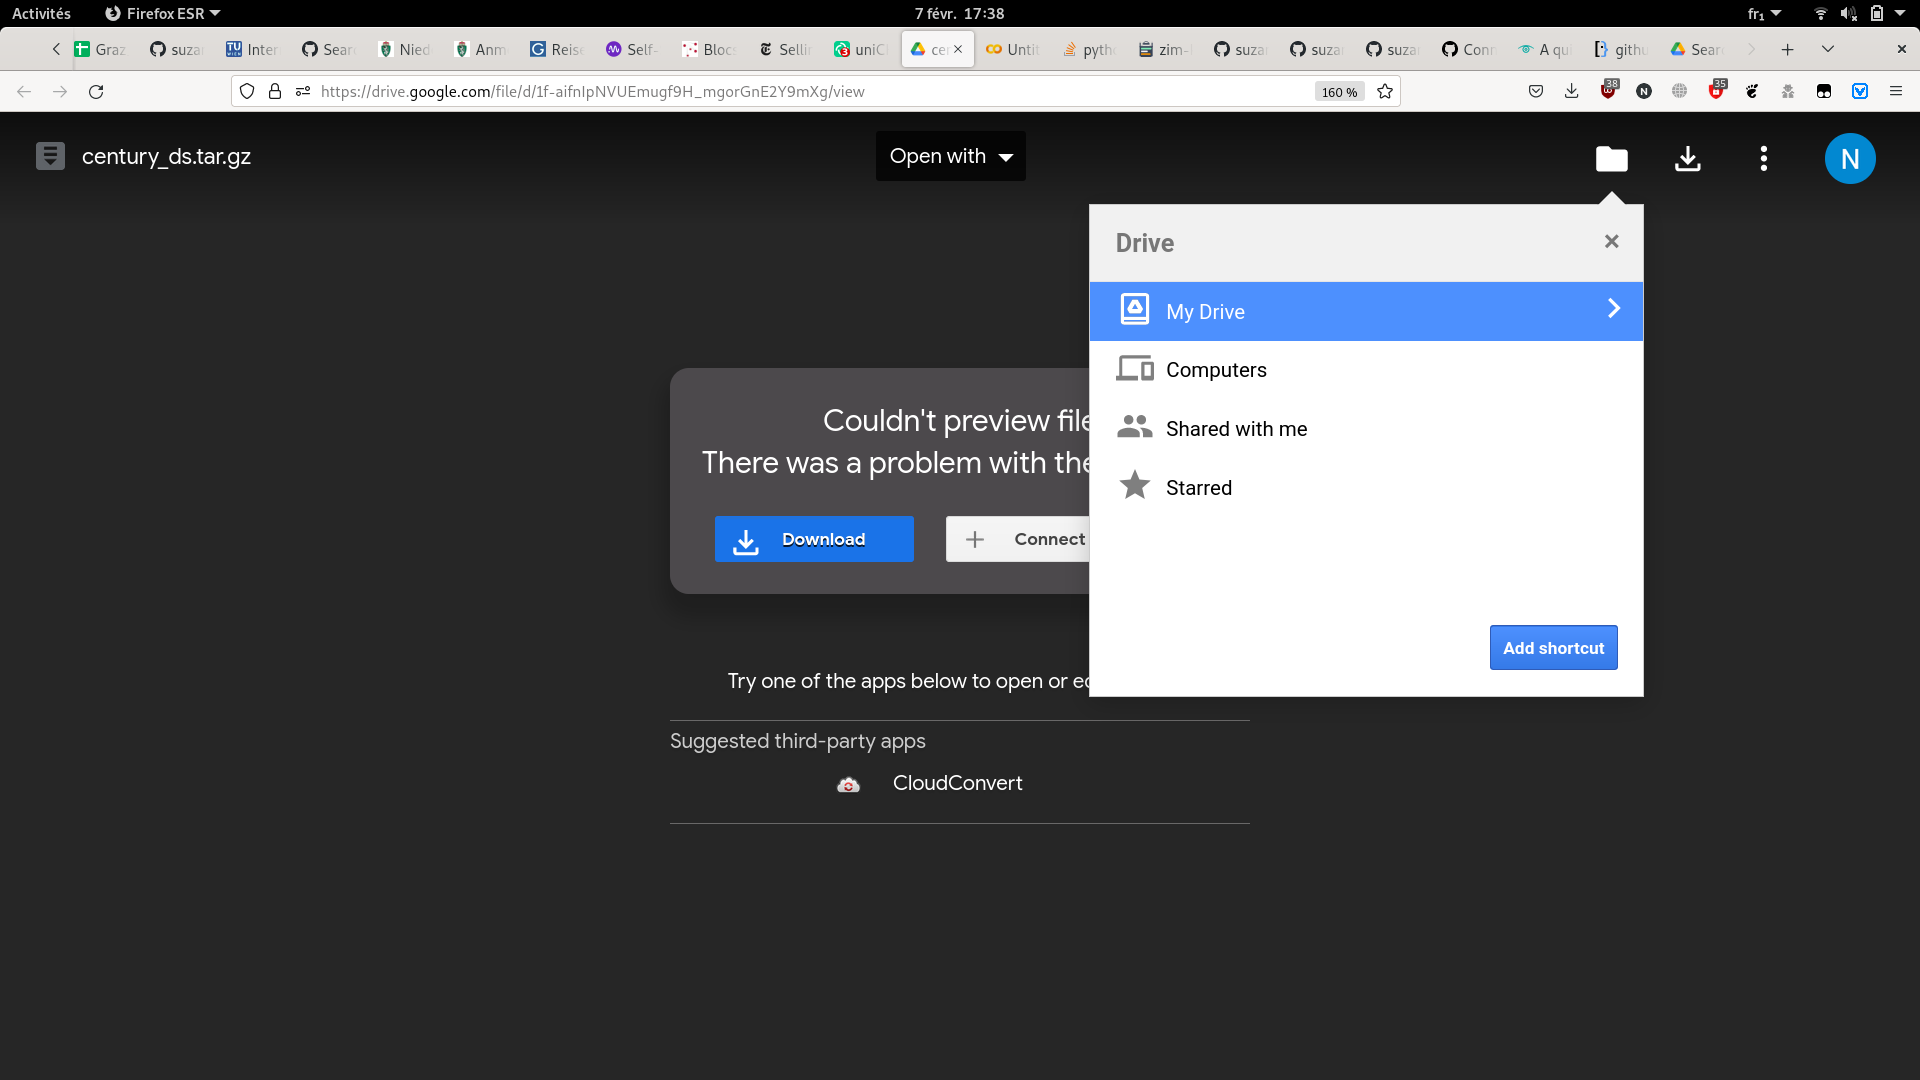

3)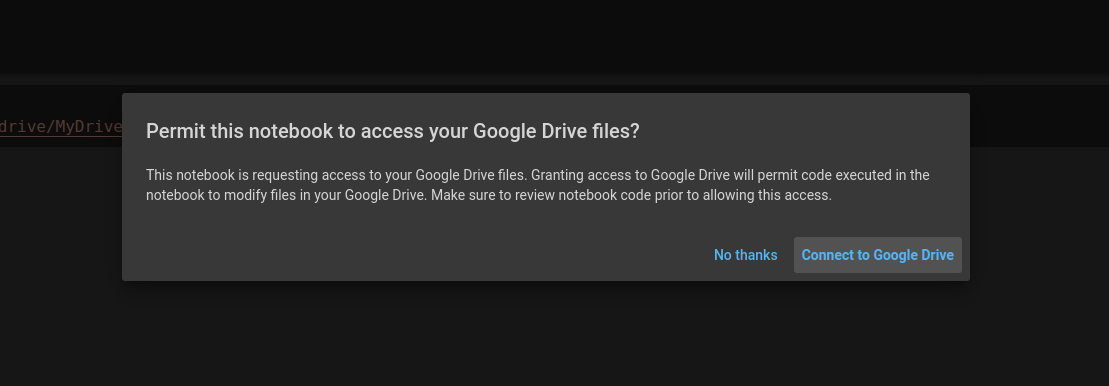

4) Authorize with the google account you used for the shortcut



4) Authorize with the google account you used for the shortcut
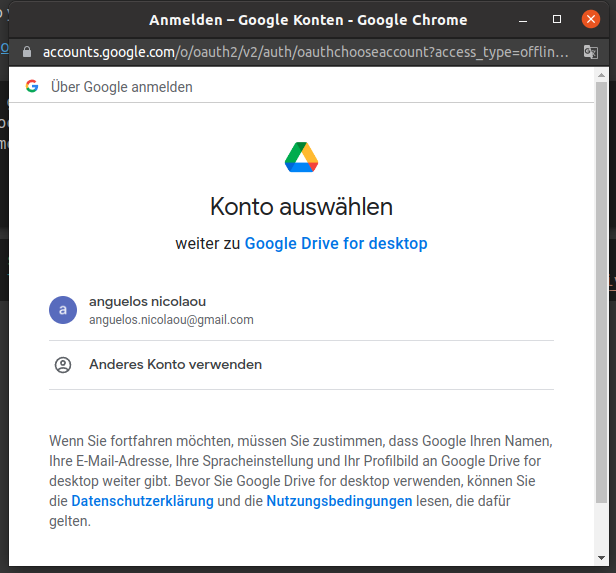

5)Make sure you agree with granting those permission to google.colab
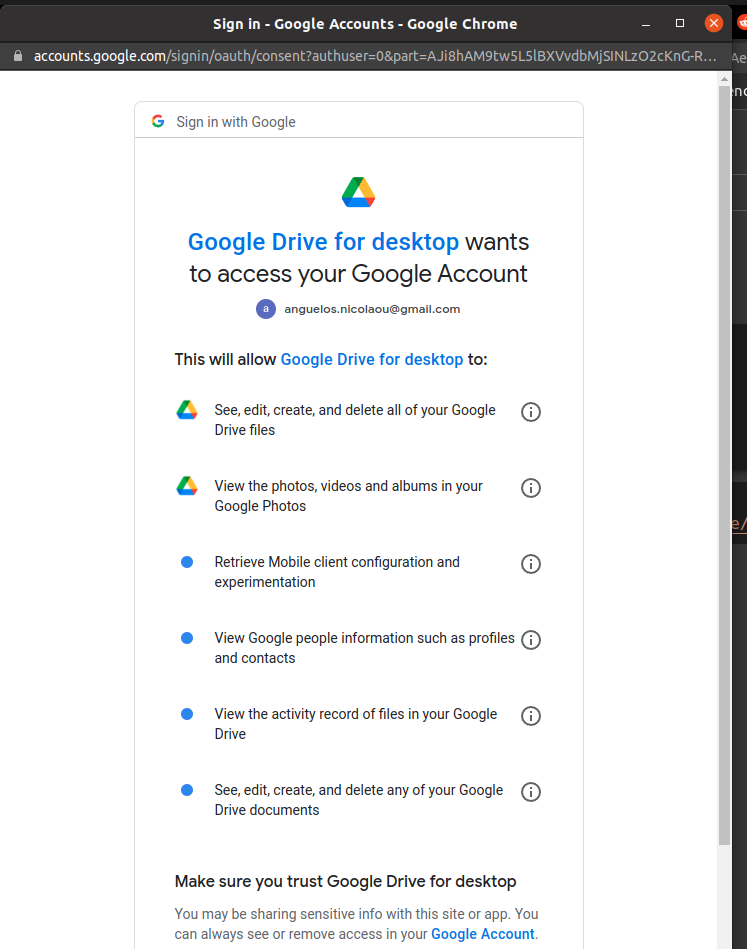

6)Never forget this is using 442 MB of you google drive storage until you delete it

Mount our google drive into our colab virtual machine

In [20]:
import glob
from google.colab import drive
#if len(glob.glob("/mnt/drive/*")) == 0:
drive.mount("/mnt/drive", force_remount=True)

Mounted at /mnt/drive


Did we succeed?

In [21]:
# Diwe succeed????
assert list(glob.glob("/mnt/drive/MyDrive/century_*gz"))[0]=="/mnt/drive/MyDrive/century_ds.tar.gz"

Lets unzip the dataset

In [22]:
!tar -xpvzf /mnt/drive/MyDrive/century_ds.tar.gz > /dev/null

In [23]:
!pip install --upgrade tensorboardX

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Data Loading 

Outline of the steps involved in creating and training a classification model to predict whether a photo was taken in 19th or 20th century. Briefly, the steps will be:

- Load the data
- Create a model
- Train the model

In [24]:
import os
import glob
import torch
import torchvision
from PIL import Image
import random
from tqdm.auto import tqdm as tqdm
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from matplotlib import pyplot as plt
import numpy

#import torchvision.utils as vutils



Checking for device:

In [25]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Working on {device}")

Working on cpu


# Preprocessing

Usually, we are going to start to build our Deep Learning pipeline with preprocessing (=transformation process).

This is a process to change the original values of image pixels to a set of new values.

One type of transformation that we do on images is to transform an image into a PyTorch tensor.


In [26]:
preprocess = torchvision.transforms.Compose([
    lambda x:x.convert("RGB"),
    torchvision.transforms.CenterCrop((150,150)), #make sure, all the pictures are the same size
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize([0.5,0.5,0.5], [0.5,0.5,0.5])
])

### Why images of the same size (and channels)?

Variable sized images cannot be combined in a batch!

_A batch, for PyTorch, will be transformed to a single Tensor input with one extra dimension. For example, if you provide a list of n images, each of the size [1, 3, 384, 320], PyTorch will stack them, so that your model has a single Tensor input, of the shape [n, 1, 3, 384, 320]. This "stacking" can only happen between images of the same shape.
(https://stackoverflow.com/questions/62719641/why-pytorch-model-takes-multiple-image-size-inside-the-model)_


#### Why normalization?

_The normalization of images is a very good practice when we work with deep neural networks. Normalizing the images means transforming the images into such values that the mean and standard deviation of the image become 0.0 and 1.0 respectively. Normalization helps get data within a range and reduces the skewness which helps learn faster and better. Normalization can also tackle the diminishing and exploding gradients problems. 
(https://www.geeksforgeeks.org/how-to-normalize-images-in-pytorch/)_

# PyTorch Dataset and DataLoader

#### ImageFolder

This class helps us to easily create PyTorch training and validation datasets __without writing custom classes__. Then we can use these datasets to create our __iterable data loaders__.

Option 1 - ImageFolder class (https://pytorch.org/vision/main/generated/torchvision.datasets.ImageFolder.html) 

Option 2 - a custom class (https://pytorch.org/tutorials/beginner/basics/data_tutorial.html?highlight=dataset)


## Iterable data loaders?

Training a whole dataset might be very time-consuming and can cause a memory-oveload, if we did gradient calculation on whole data. 

A better way is to divide samples into smaller batches. To do that, we will create a Dataloader, that helps load data into a model. Dataloader will basically make a batch iteration and calculation for us.  

_(DataLoader class is available in the torch.utils.data module.)_

__DataLoader will be used in our training loop.__

You need to parse the data as a PyTorch Dataset before passing it to DataLoader!

In [ ]:
# #Dataloader --> Option 1:

# #Path to directory containig ...
# img_dir='../data/century_ds/'

# batch_size = 32
# labels = ("19","20")

# orig_ds = torchvision.datasets.ImageFolder(img_dir,transform=preprocess)
# #Our dataset is now in the form of PyTorch Dataset

# #Next step is to devide the dataset into Training and Test dataset

# # get num of indices
# i_num = len(orig_ds)

# # generate & shuffle indices
# indices = numpy.arange(i_num)
# indices = numpy.random.permutation(indices)

# train_indices = indices [:800]
# test_indices = indices[800:]


# train_ds = torch.utils.data.Subset(orig_ds, train_indices)  # first 800
# test_ds = torch.utils.data.Subset(orig_ds, test_indices)  # last 498

# train_dl = torch.utils.data.DataLoader(train_ds, batch_size = batch_size, shuffle = True)
# test_dl = torch.utils.data.DataLoader(test_ds, batch_size = batch_size, shuffle = True)


In [27]:
#Dataloader --> Option 2:

#List of paths to images...

img_paths=list(glob.glob("century_ds/*/*.jpg"))
print(f"Loaded {len(img_paths)} images")

#Shuffle
shuffled_paths = [p for p in img_paths]
random.Random(1337).shuffle(shuffled_paths) # Random(1337); Stabillity while mixing classes for balanced partitioning

train_paths, test_paths = shuffled_paths[:800], shuffled_paths[800:]

default_labels = ("19","20")
class CenturyDs(object):
    def __init__(self, img_paths, labels=default_labels, preprocessor=preprocess, label_idx=-2):
        self.img_paths = img_paths
        self.preprocessor=preprocessor
        self.labels = [cl for cl in labels]
        self.label_idx = label_idx

    def __getitem__(self, n):
        path = self.img_paths[n]
        img = Image.open(path) # Img is a PIL.Image
        img = self.preprocessor(img)# Img is now a 3D tensor
        label = path.split("/")[self.label_idx]
        #print(f"path:{path}  label:{label}")
        cl_id = self.labels.index(label)  # id is 0,1
        return img, cl_id
        
    def __len__(self):
        return len(self.img_paths)

Loaded 1298 images


In [28]:
batch_size = 32


In [29]:

train_ds = CenturyDs(train_paths,preprocessor = preprocess)
test_ds = CenturyDs(test_paths,preprocessor = preprocess)

train_dl = torch.utils.data.DataLoader(train_ds, batch_size = batch_size, shuffle = True)
test_dl = torch.utils.data.DataLoader(test_ds, batch_size = batch_size, shuffle = True)

0
torch.Size([3, 150, 150])


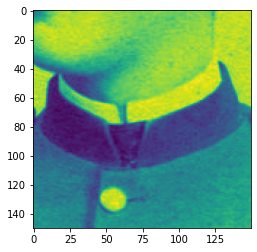

In [30]:
x, y = train_ds[8]
plt.imshow(x.numpy()[0])
print(y)
print(x.shape)

# --------------------------------------------------------------------------------------------------------------------------------------------

# Create a model

In [31]:
class OurNet(nn.Module):
    def __init__(self, n_channels=3):
        super().__init__()
        self.conv1 = nn.Conv2d(n_channels, 16, 5)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, 5)
        self.pool2 = nn.MaxPool2d(2, 2)
        
        self.conv3 = nn.Conv2d(32, 64, 3)
        self.pool3 = nn.MaxPool2d(2, 2)
        self.conv4 = nn.Conv2d(64, 128, 3)
        self.pool4 = nn.MaxPool2d(2, 2)
        
        self.conv5 = nn.Conv2d(128, 256, 3, padding=1)
        self.pool5 = nn.MaxPool2d(2, 2)
        self.conv6 = nn.Conv2d(256, 512, 3, padding=1)
        self.pool6 = nn.MaxPool2d(2, 2)
        
        self.fc1 = nn.Linear(512, 1024)
        self.fc2 = nn.Linear(1024, 768)
        self.fc3 = nn.Linear(768, 2)

    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = self.pool3(F.relu(self.conv3(x)))
        x = self.pool4(F.relu(self.conv4(x)))
        x = self.pool5(F.relu(self.conv5(x)))
        x = self.pool6(F.relu(self.conv6(x)))
        #print(x.size())
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

def count_parameters(model):
  return sum([t.view(-1).size(0) for t in model.parameters()])

print(f"OurNet size={count_parameters(OurNet())}")

OurNet size=2895778


In [32]:
model = OurNet(n_channels=3)

lr = 1e-3 # 1e-3 is a default lr value for Adam
optimizer = optim.Adam(model.parameters(), lr=lr)

lossfn = nn.CrossEntropyLoss()


### Training

In [33]:


def train_epoch(dl, model, optimiser, lossfn, device=device, epochnum=-1):
    model = model.to(device) # redundant
    model.train(True) # make it train mode
    predictions, targets, losses = [], [], []
    
    for input_batch, target_batch in tqdm(dl):
        input_batch, target_batch = input_batch.to(device), target_batch.to(device)
        optimiser.zero_grad() # reset gradient accumulation
        output_batch = model(input_batch)
        _, batch_prediction = output_batch.detach().max(dim=1)
        loss = lossfn(output_batch,target_batch)
        loss.backward()# minize
        optimiser.step() # apply gradients on the weight
        _, batch_prediction = output_batch.detach().max(dim=1)
        losses.append(loss.detach())
        predictions.append(batch_prediction)
        targets.append(target_batch.detach())
    predictions, targets = [torch.cat(t, dim=0).cpu().numpy() for t in (predictions, targets)]
    acc = (predictions==targets).mean()
    return acc, predictions, targets, losses 



### Evaluation

In [34]:
def eval_epoch(dl, model, device=device):
    model = model.to(device) # redundant
    model.train(False) # no train mode
    predictions, targets = [], []
    with torch.no_grad():
        for input_batch, target_batch in tqdm(dl):
            input_batch, target_batch = input_batch.to(device), target_batch.to(device)
            output_batch = model(input_batch)
            confidence, batch_prediction = output_batch.max(dim=1)
            predictions.append(batch_prediction)
            targets.append(target_batch)

    predictions, targets = [torch.cat(t, dim=0).cpu().numpy() for t in (predictions, targets)]
    acc = (predictions==targets).mean()
    # anguelos: better avoid printing inside a function returning accuracy
    return acc, predictions, targets, confidence

accuracy, all_predictions, all_gt, confidences = eval_epoch(test_dl, model, device=device)
print(accuracy)

  0%|          | 0/16 [00:00<?, ?it/s]

0.4839357429718876


# Train the model

### Optimizing and evaluating the model over the number of epochs:

In [35]:
for epoch in range(3):
    tr_acc, tr_predictions, tr_targets, tr_losses = train_epoch(train_dl, model, optimizer, lossfn, device=device)
    val_acc, val_predictions, val_targets, val_confidences = eval_epoch(test_dl, model, device=device)

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

In [ ]:
accuracy, all_predictions, all_gt, confidences = eval_epoch(test_dl, model, device=device)
print(accuracy)

  0%|          | 0/16 [00:00<?, ?it/s]

0.7951807228915663
